In [62]:
import polars as pl, matplotlib.pyplot as plt, datetime, matplotlib.dates as mdates, matplotlib.ticker as mticker, geopandas as gpd, matplotlib.colors as colors, contextily as ctx, pandas as pd, numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.ticker import AutoMinorLocator
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib.patches import Patch
from xgboost import XGBRegressor

In [10]:
data = '../data/london_burglaries.parquet'
burglaries = pd.read_parquet(data)
lsoa_gdf = gpd.read_file('../data/geo/london_lsoa.gpkg')
resi = pl.read_csv("../data/geo/lsoa_residential_classification_2018.csv")
burglaries.head()

Crime ID    Month  \
0  791aac04e462f0067de943d7ab614abf4b6f3625dc23c7...  2016-11   
1  9e1b82e34d63c9c664c0392f0c19a70055caf451ab8fca...  2017-09   
2  38603b3f618d852c76c42e3adc922d257a0410654db6aa...  2014-02   
3  1030d70e764c6767dcc547a5abfe992b5fdcd033d58e38...  2015-12   
4  fce2d7d86230c84780ea0af8be9b08fb27352d18025d5c...  2019-01   

                   Reported by                 Falls within  Longitude  \
0  Metropolitan Police Service  Metropolitan Police Service  -0.198566   
1  Metropolitan Police Service  Metropolitan Police Service  -0.010729   
2  Metropolitan Police Service  Metropolitan Police Service  -0.011973   
3  Metropolitan Police Service  Metropolitan Police Service   0.212525   
4  Metropolitan Police Service  Metropolitan Police Service  -0.023290   

    Latitude                        Location  LSOA code            LSOA name  \
0  51.643150         On or near Meadow Close  E01000289          Barnet 004D   
1  51.628661    On or near Mount Echo Avenue  E01004357  Waltham Forest 001E   
2  51.448632       On or near Sycamore Grove  E01003323        Lewisham 018C   
3  51.548478  On or near Ilfracombe Crescent  E01002286        Havering 025C   
4  51.507806       On or near Hertsmere Road  E01004277   Tower Hamlets 033A   

  Crime type                          Last outcome category Context  
0   Burglary  Investigation complete; no suspect identified    None  
1   Burglary  Investigation complete; no suspect identified    None  
2   Burglary  Investigation complete; no suspect identified    None  
3   Burglary                            Under investigation    None  
4   Burglary  Investigation complete; no suspect identified    None

In [3]:
# Count burglaries per LSOA
burglary_counts = burglaries.groupby('LSOA code').size().reset_index(name='burglary_count')

# Merge the count data with the geographic data
lsoa_with_counts = lsoa_gdf.merge(burglary_counts, left_on='LSOA21CD', right_on='LSOA code', how='left')

# Fill NaN values with 0 (LSOAs with no recorded burglaries)
lsoa_with_counts['burglary_count'] = lsoa_with_counts['burglary_count'].fillna(0)

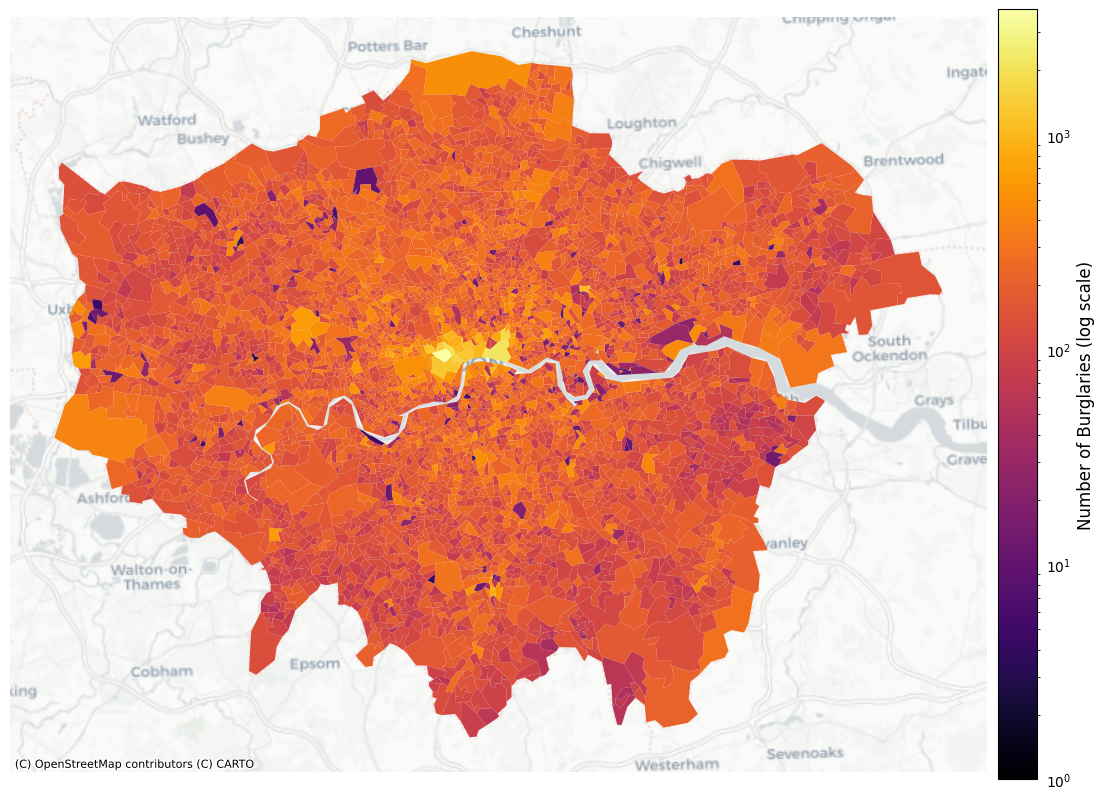


Top 10 LSOAs with highest burglary counts:
       LSOA21CD             LSOA21NM  burglary_count
4987  E01035716     Westminster 013G          3850.0
4536  E01032739  City of London 001F          2208.0
4504  E01004763     Westminster 013B          1960.0
4636  E01033708         Hackney 033C          1751.0
4480  E01004734     Westminster 018A          1614.0
4505  E01004765     Westminster 013D          1494.0
4481  E01004735     Westminster 018B          1304.0
4502  E01004761     Westminster 018D          1281.0
4460  E01004714     Westminster 011B          1256.0
4482  E01004736     Westminster 018C          1246.0


In [4]:
# Set figure background to dark
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor='white')
ax.set_facecolor('#121212')  # Dark background for the plotting area

# Create a custom colormap for better visualization
vmin = lsoa_with_counts['burglary_count'].min()
vmax = lsoa_with_counts['burglary_count'].max()

# Plot with normal scale
lsoa_map = lsoa_with_counts.plot(
    column='burglary_count',
    ax=ax,
    cmap='inferno',
    norm=colors.LogNorm(vmin=max(1, vmin), vmax=vmax),
    legend=False,
    legend_kwds={'label': 'Number of Burglaries (log scale)'}
)

# Add dark basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    crs=lsoa_with_counts.crs.to_string()
)

# Create a custom colorbar/legend
sm = ScalarMappable(norm=colors.LogNorm(vmin=max(1, vmin), vmax=vmax), cmap='inferno')
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.01)
cbar.set_label('Number of Burglaries (log scale)', color='black', size=12)
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

# Add title and labels
# plt.title('Burglaries per LSOA in London (2011-12 - 2025-02) log scaled', fontsize=16,color='black')
plt.axis('off')

# Save the plot
plt.savefig('london_burglaries_per_lsoa_log_scaled.png', dpi=300, bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()

# Optional: Create a table of top 10 LSOAs with highest burglary counts
top_lsoas = lsoa_with_counts.sort_values('burglary_count', ascending=False).head(10)
top_lsoas_table = top_lsoas[['LSOA21CD', 'LSOA21NM', 'burglary_count']]
print("\nTop 10 LSOAs with highest burglary counts:")
print(top_lsoas_table)

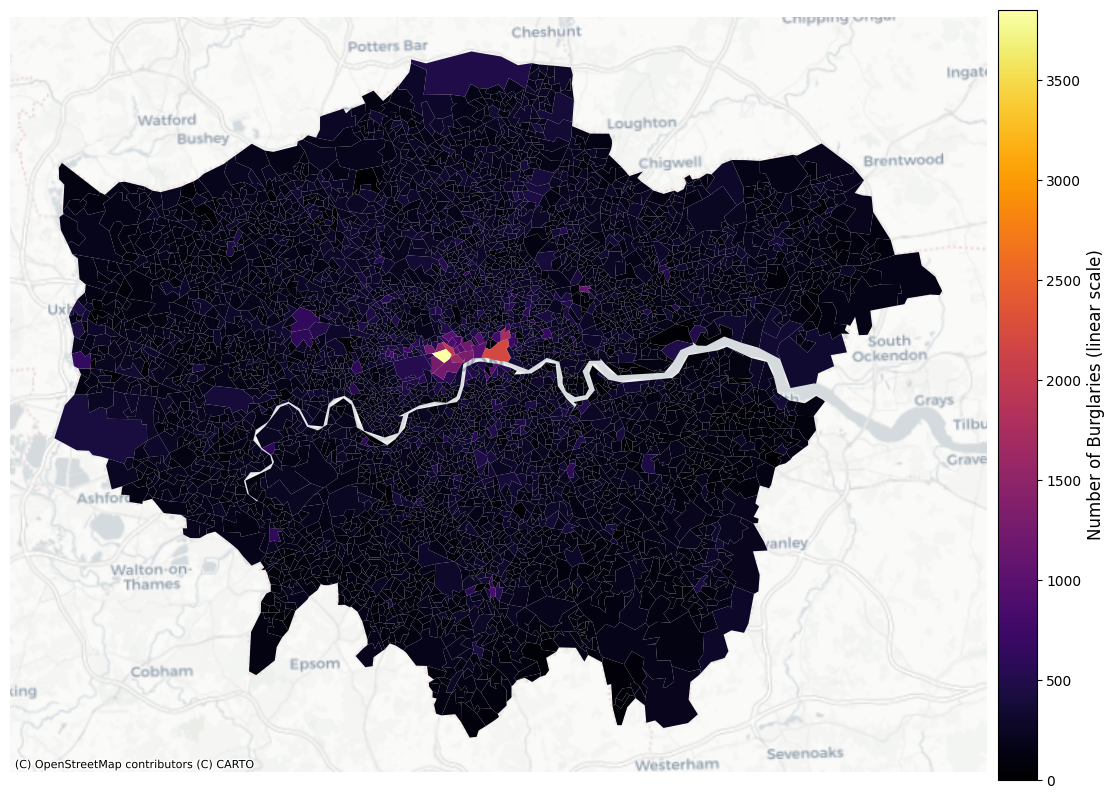


Top 10 LSOAs with highest burglary counts:
       LSOA21CD             LSOA21NM  burglary_count
4987  E01035716     Westminster 013G          3850.0
4536  E01032739  City of London 001F          2208.0
4504  E01004763     Westminster 013B          1960.0
4636  E01033708         Hackney 033C          1751.0
4480  E01004734     Westminster 018A          1614.0
4505  E01004765     Westminster 013D          1494.0
4481  E01004735     Westminster 018B          1304.0
4502  E01004761     Westminster 018D          1281.0
4460  E01004714     Westminster 011B          1256.0
4482  E01004736     Westminster 018C          1246.0


In [5]:
# ---------- FIGURE & AXES (defaults give a white background) ---------------
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# ---------- COLOUR MAP (linear scale) --------------------------------------
vmin = lsoa_with_counts['burglary_count'].min()
vmax = lsoa_with_counts['burglary_count'].max()
norm = Normalize(vmin=vmin, vmax=vmax)

lsoa_with_counts.plot(column='burglary_count', ax=ax, cmap='inferno', norm=norm, legend=False)

# ---------- LIGHT BASEMAP ---------------------------------------------------
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=lsoa_with_counts.crs.to_string())

# ---------- COLOUR BAR / LEGEND --------------------------------------------
sm = ScalarMappable(norm=norm, cmap='inferno')
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.01)
cbar.set_label('Number of Burglaries (linear scale)', size=12)
cbar.ax.yaxis.set_tick_params(color='black')
plt.setp(cbar.ax.get_yticklabels(), color='black')

# ---------- TITLE & CLEAN-UP ------------------------------------------------
# plt.title(
#     'Burglaries per LSOA in London (2011-12 – 2025-02), linear scale',
#     fontsize=16,
#     color='black'
# )
plt.axis('off')

# ---------- SAVE & SHOW -----------------------------------------------------
plt.savefig('london_burglaries_per_lsoa_linear_scaled.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------- OPTIONAL: Top-10 LSOAs -----------------------------------------
top_lsoas = (
    lsoa_with_counts.sort_values('burglary_count', ascending=False)
                    .head(10)[['LSOA21CD', 'LSOA21NM', 'burglary_count']]
)
print("\nTop 10 LSOAs with highest burglary counts:")
print(top_lsoas)


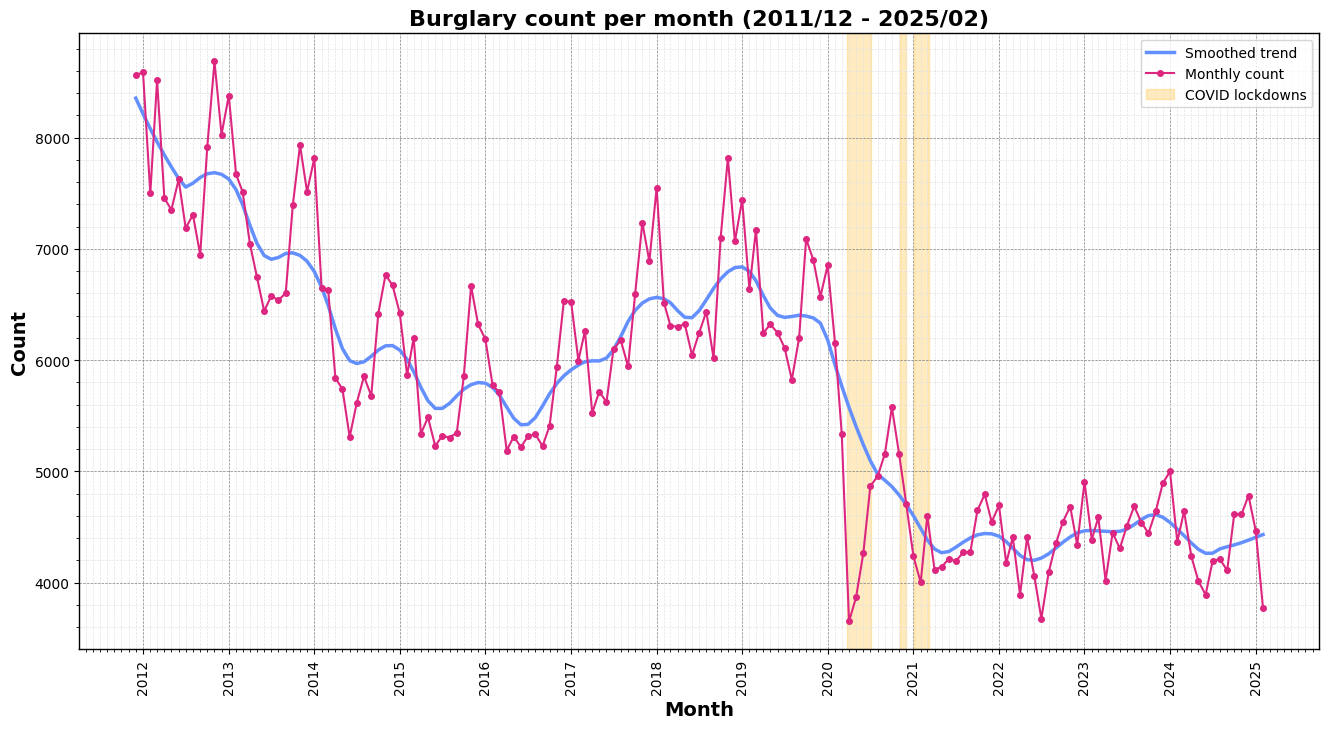

In [7]:
crimes = pl.read_parquet(data).sort("Month")

crimes_count = crimes.group_by("Month").agg(pl.len())
crimes_count = crimes_count.sort('Month')

# Convert month strings to datetime objects
date_list = [datetime.datetime.strptime(x, "%Y-%m") for x in crimes_count["Month"].to_list()]

# Covid lockdown 1
highlight_start = datetime.datetime(2020,  3, 23)   # 23 Mar 2020
highlight_end   = datetime.datetime(2020,  7, 4)    # 4 Jul 2020

# Covid lockdown 2
highlight_start2 = datetime.datetime(2020,  11, 5)   # 5 Nov 2020
highlight_end2   = datetime.datetime(2020,  12, 2)   # 12 Dec 2020

# Covid lockdown 3
highlight_start3 = datetime.datetime(2021,  1, 4)   # 1 Jan 2021
highlight_end3   = datetime.datetime(2021,  3, 8)   # 8 Mar 2021

# Determine the start date (January 1st of the earliest year)
start_year = min(date.year for date in date_list)
start_date = datetime.datetime(start_year, 1, 1)

# Convert datetime objects for plotting
x = mdates.date2num(date_list)
y = crimes_count['len'].to_numpy()
smooth_y = lowess(y, x, frac=0.10, return_sorted=False)

# Create figure and axes with customized backgrounds
fig, ax = plt.subplots(figsize=(16, 8), facecolor='white')
ax.set_facecolor("white")

# Plot the data
ax.plot(x, smooth_y, linewidth=2.5, color='#648FFF', label='Smoothed trend')
ax.plot(x, y, marker='o', markersize=4, color='#DC267F', label='Monthly count')


# --- x-axis locators -------------------------------------------------------
ax.xaxis.set_major_locator(mdates.YearLocator())           #  1-Jan every year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))   # optional: show just the year
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))  # every month

ax.yaxis.set_minor_locator(AutoMinorLocator())

# --- gridlines -------------------------------------------------------------
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray')
ax.grid(True, which='minor', linestyle='--', linewidth=0.5, color='#e3e3e3')
ax.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.5, color='#e3e3e3')

# **Add a black outline (border) to the plot by customizing the spines**
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Draw vertical box
ax.axvspan(
    mdates.date2num(highlight_start),
    mdates.date2num(highlight_end),
    color='#FFB000',
    alpha=0.25,
    label='COVID lockdowns'
)
ax.axvspan(
    mdates.date2num(highlight_start2),
    mdates.date2num(highlight_end2),
    color='#FFB000',
    alpha=0.25,
)
ax.axvspan(
    mdates.date2num(highlight_start3),
    mdates.date2num(highlight_end3),
    color='#FFB000',
    alpha=0.25,
)

ax.legend(loc='upper right')

# Rotate x-axis tick labels
plt.xticks(rotation=90)

# Set axis labels and title
plt.xlabel("Month", fontweight='bold', fontsize=14)
plt.ylabel("Count", fontweight='bold', fontsize=14)
plt.title("Burglary count per month (2011/12 - 2025/02)", fontweight='bold', fontsize=16)
plt.savefig('monthly_burglary_counts.png', dpi=300, bbox_inches='tight')
plt.show();

Total LSOAs in London: 4994
Residential-dominant LSOAs: 4366
Percentage residential: 87.4%


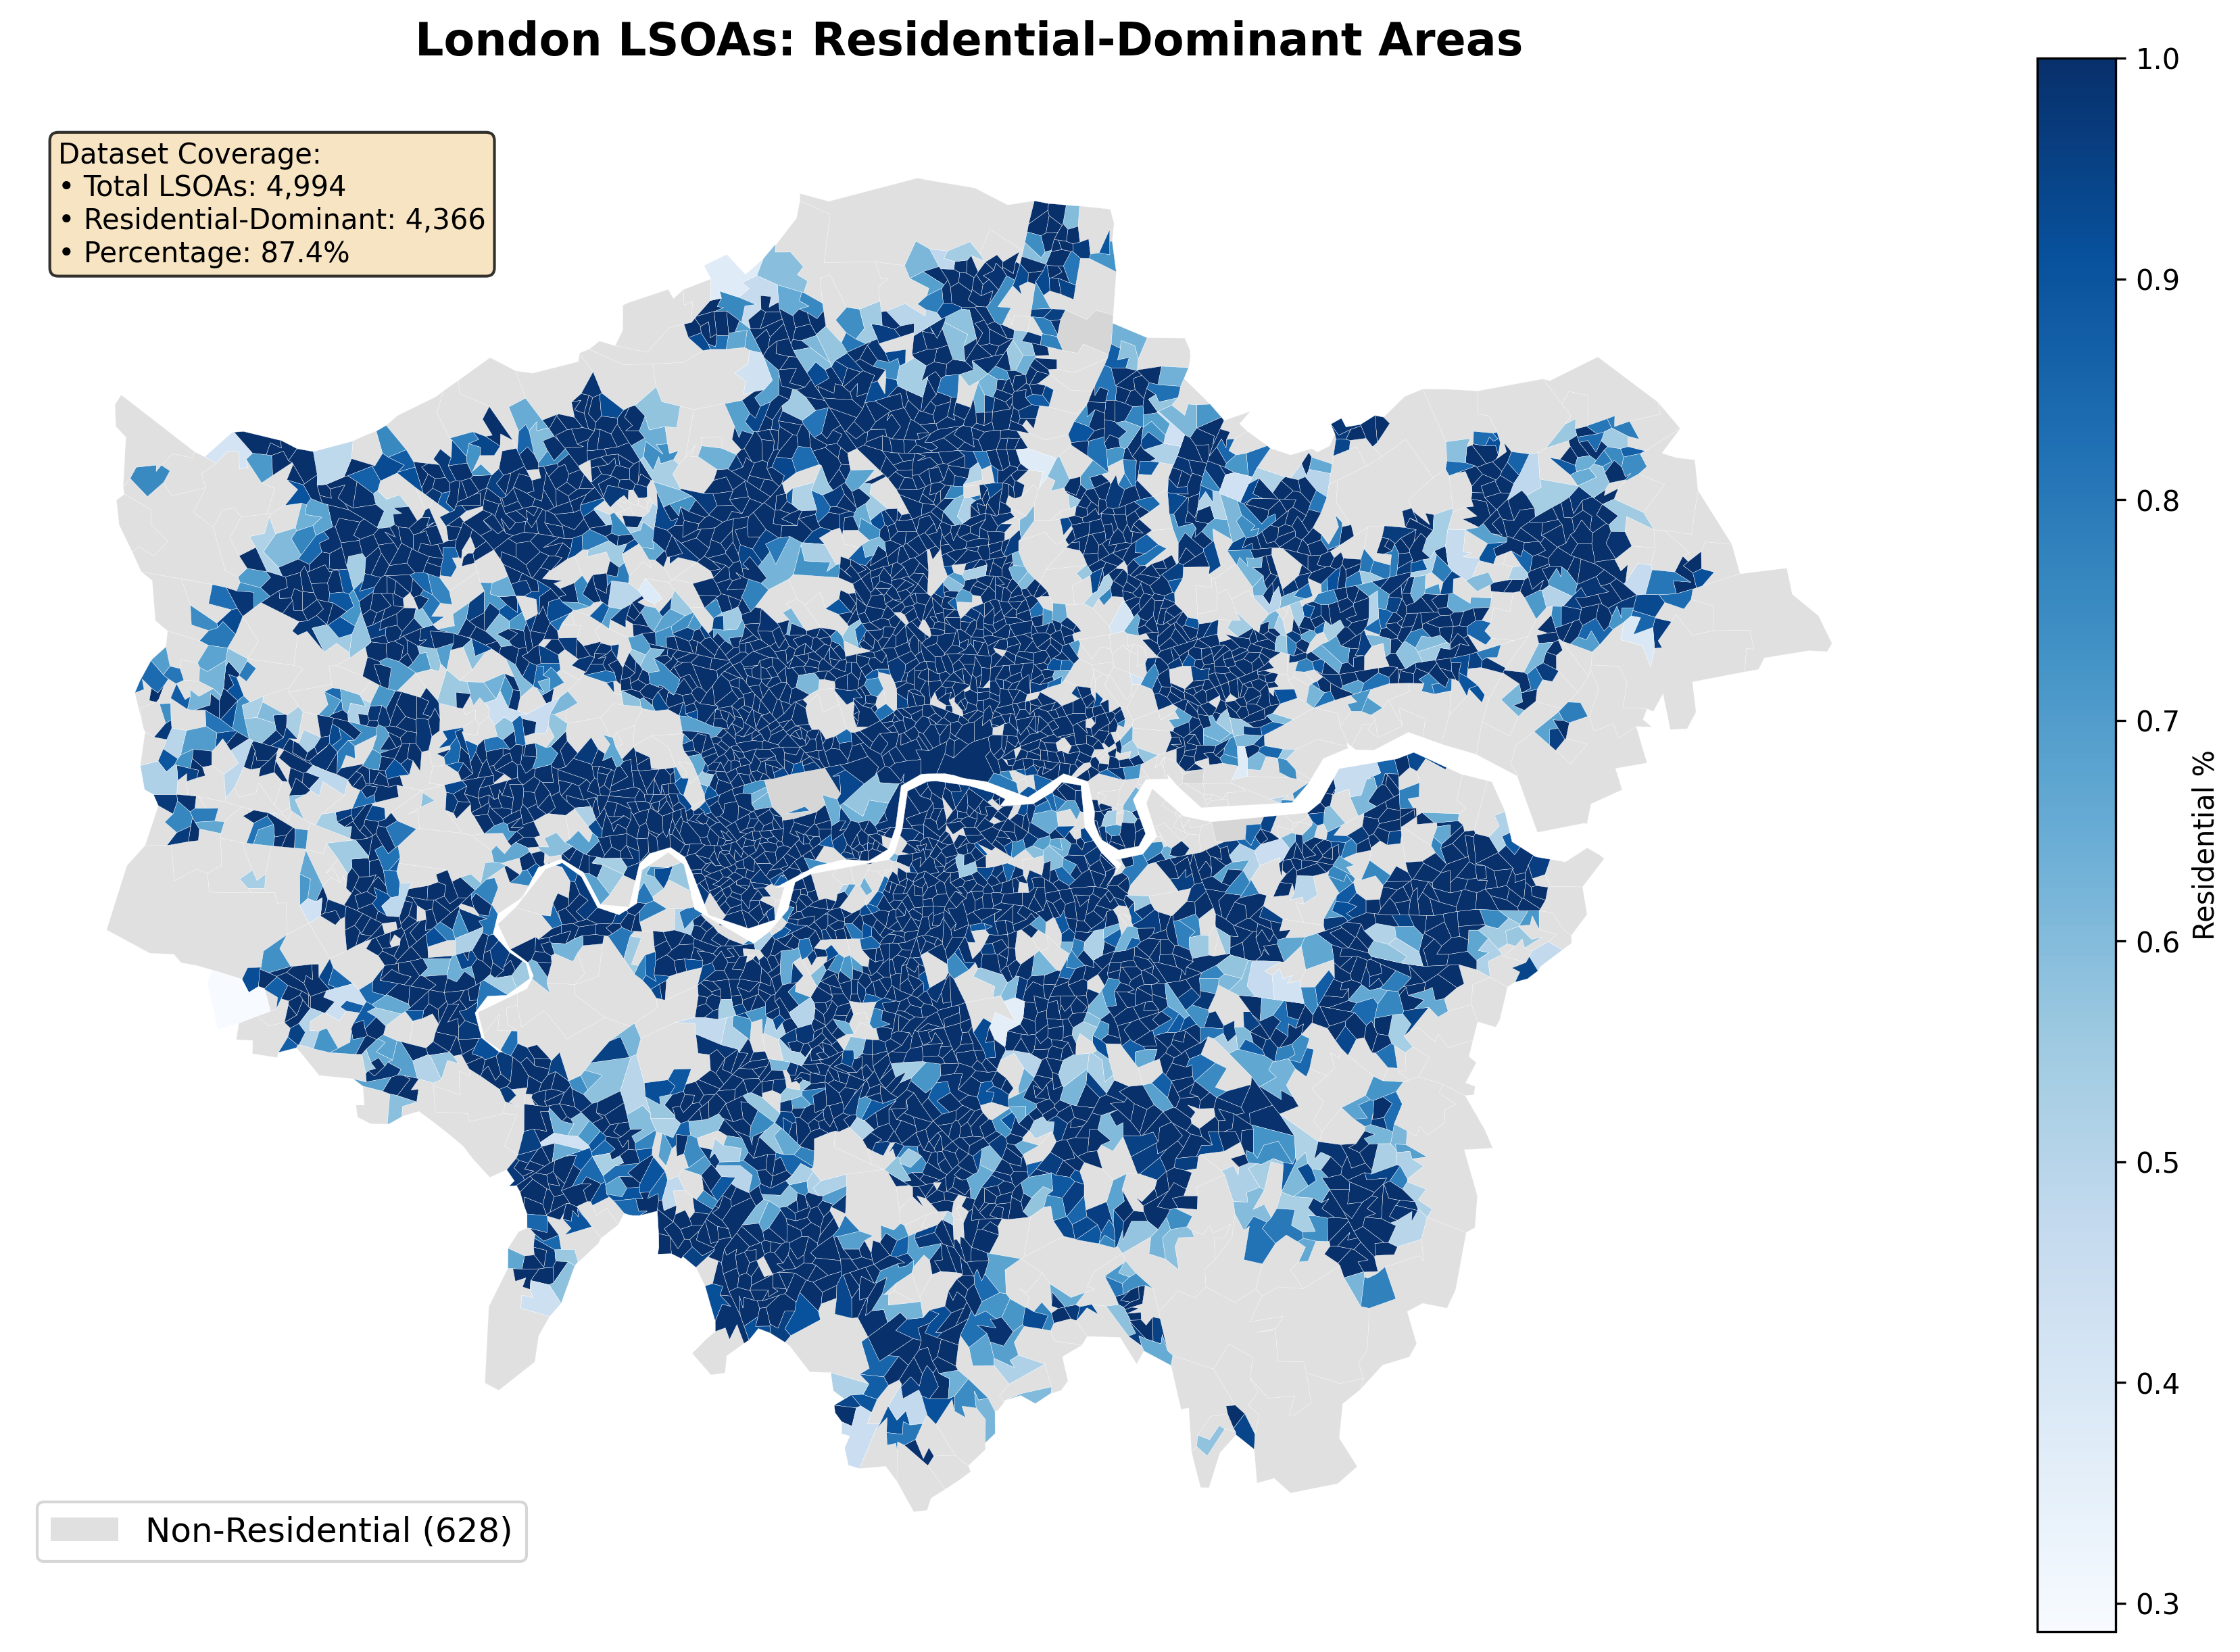


Residential Classification Summary:
Average residential percentage: 0.9%
Median residential percentage: 1.0%

Residential Advantage Statistics:
Mean advantage: 0.9%
Range: 0.0% to 1.0%


In [11]:
# Filter for residential-dominant LSOAs
residential_lsoas = resi.filter(pl.col("is_residential_dominant") == True)
residential_codes = residential_lsoas.select("LSOA21CD").to_series().to_list()

print(f"Total LSOAs in London: {len(lsoa_gdf)}")
print(f"Residential-dominant LSOAs: {len(residential_codes)}")
print(f"Percentage residential: {len(residential_codes)/len(lsoa_gdf)*100:.1f}%")

# Merge residential data with geographic data
resi_pandas = resi.to_pandas()
london_gdf_merged = lsoa_gdf.merge(resi_pandas[['LSOA21CD', 'residential_pct_2018', 'is_residential_dominant']],
                                     on='LSOA21CD', how='left')

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(12, 10), dpi=300)

# Plot all LSOAs in light gray (non-residential or missing data)
london_gdf_merged[london_gdf_merged['is_residential_dominant'] != True].plot(
    ax=ax, color='lightgray', edgecolor='white', linewidth=0.1, alpha=0.7)

# Plot residential-dominant LSOAs with intensity based on residential_pct_2018
residential_gdf = london_gdf_merged[london_gdf_merged['is_residential_dominant'] == True]
residential_gdf.plot(ax=ax, column='residential_pct_2018', cmap='Blues',
                    edgecolor='white', linewidth=0.1, legend=True,
                    legend_kwds={'label': 'Residential %', 'shrink': 0.8})

# Styling
ax.set_title('London LSOAs: Residential-Dominant Areas', fontsize=16, fontweight='bold', pad=20)
ax.axis('off')

# Add legend
legend_elements = [
    Patch(facecolor='lightgray', alpha=0.7, label=f'Non-Residential ({len(lsoa_gdf) - len(residential_codes):,})'),
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=12)

# Add statistics text box
stats_text = f"""Dataset Coverage:
• Total LSOAs: {len(lsoa_gdf):,}
• Residential-Dominant: {len(residential_codes):,}
• Percentage: {len(residential_codes)/len(lsoa_gdf)*100:.1f}%"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Additional analysis
print("\nResidential Classification Summary:")
residential_stats = resi.select([
    pl.col("residential_pct_2018").mean().alias("avg_residential_pct"),
    pl.col("residential_pct_2018").median().alias("median_residential_pct"),
    pl.col("is_residential_dominant").sum().alias("count_residential"),
    pl.len().alias("total_count")
])

print(f"Average residential percentage: {residential_stats['avg_residential_pct'][0]:.1f}%")
print(f"Median residential percentage: {residential_stats['median_residential_pct'][0]:.1f}%")

# Show distribution of residential advantage
residential_advantage_stats = residential_lsoas.select([
    pl.col("residential_advantage").mean().alias("mean_advantage"),
    pl.col("residential_advantage").min().alias("min_advantage"),
    pl.col("residential_advantage").max().alias("max_advantage")
])

print(f"\nResidential Advantage Statistics:")
print(f"Mean advantage: {residential_advantage_stats['mean_advantage'][0]:.1f}%")
print(f"Range: {residential_advantage_stats['min_advantage'][0]:.1f}% to {residential_advantage_stats['max_advantage'][0]:.1f}%")

In [54]:
temporal_features = pl.read_parquet("../data/features.parquet")
random_lsoa = np.random.choice(temporal_features["LSOA code"].unique())
print("Random LSOA chosen:", random_lsoa)

sel = (
    temporal_features
        .filter(pl.col("LSOA code") == random_lsoa)
        .sort(["year", "month"])
)
train_dates     = pd.to_datetime({"year": sel["year"], "month": sel["month"], "day": 1})
burglary_counts = sel["burglary_count"].to_numpy()
hma_4           = sel["burglary_count_hma_4"].to_numpy().ravel()
hma_5           = sel["burglary_count_hma_5"].to_numpy().ravel()
tema_6          = sel["burglary_count_tema_6"].to_numpy().ravel()
ewm_6           = sel["burglary_count_ewm_6"].to_numpy().ravel()

Random LSOA chosen: E01002677


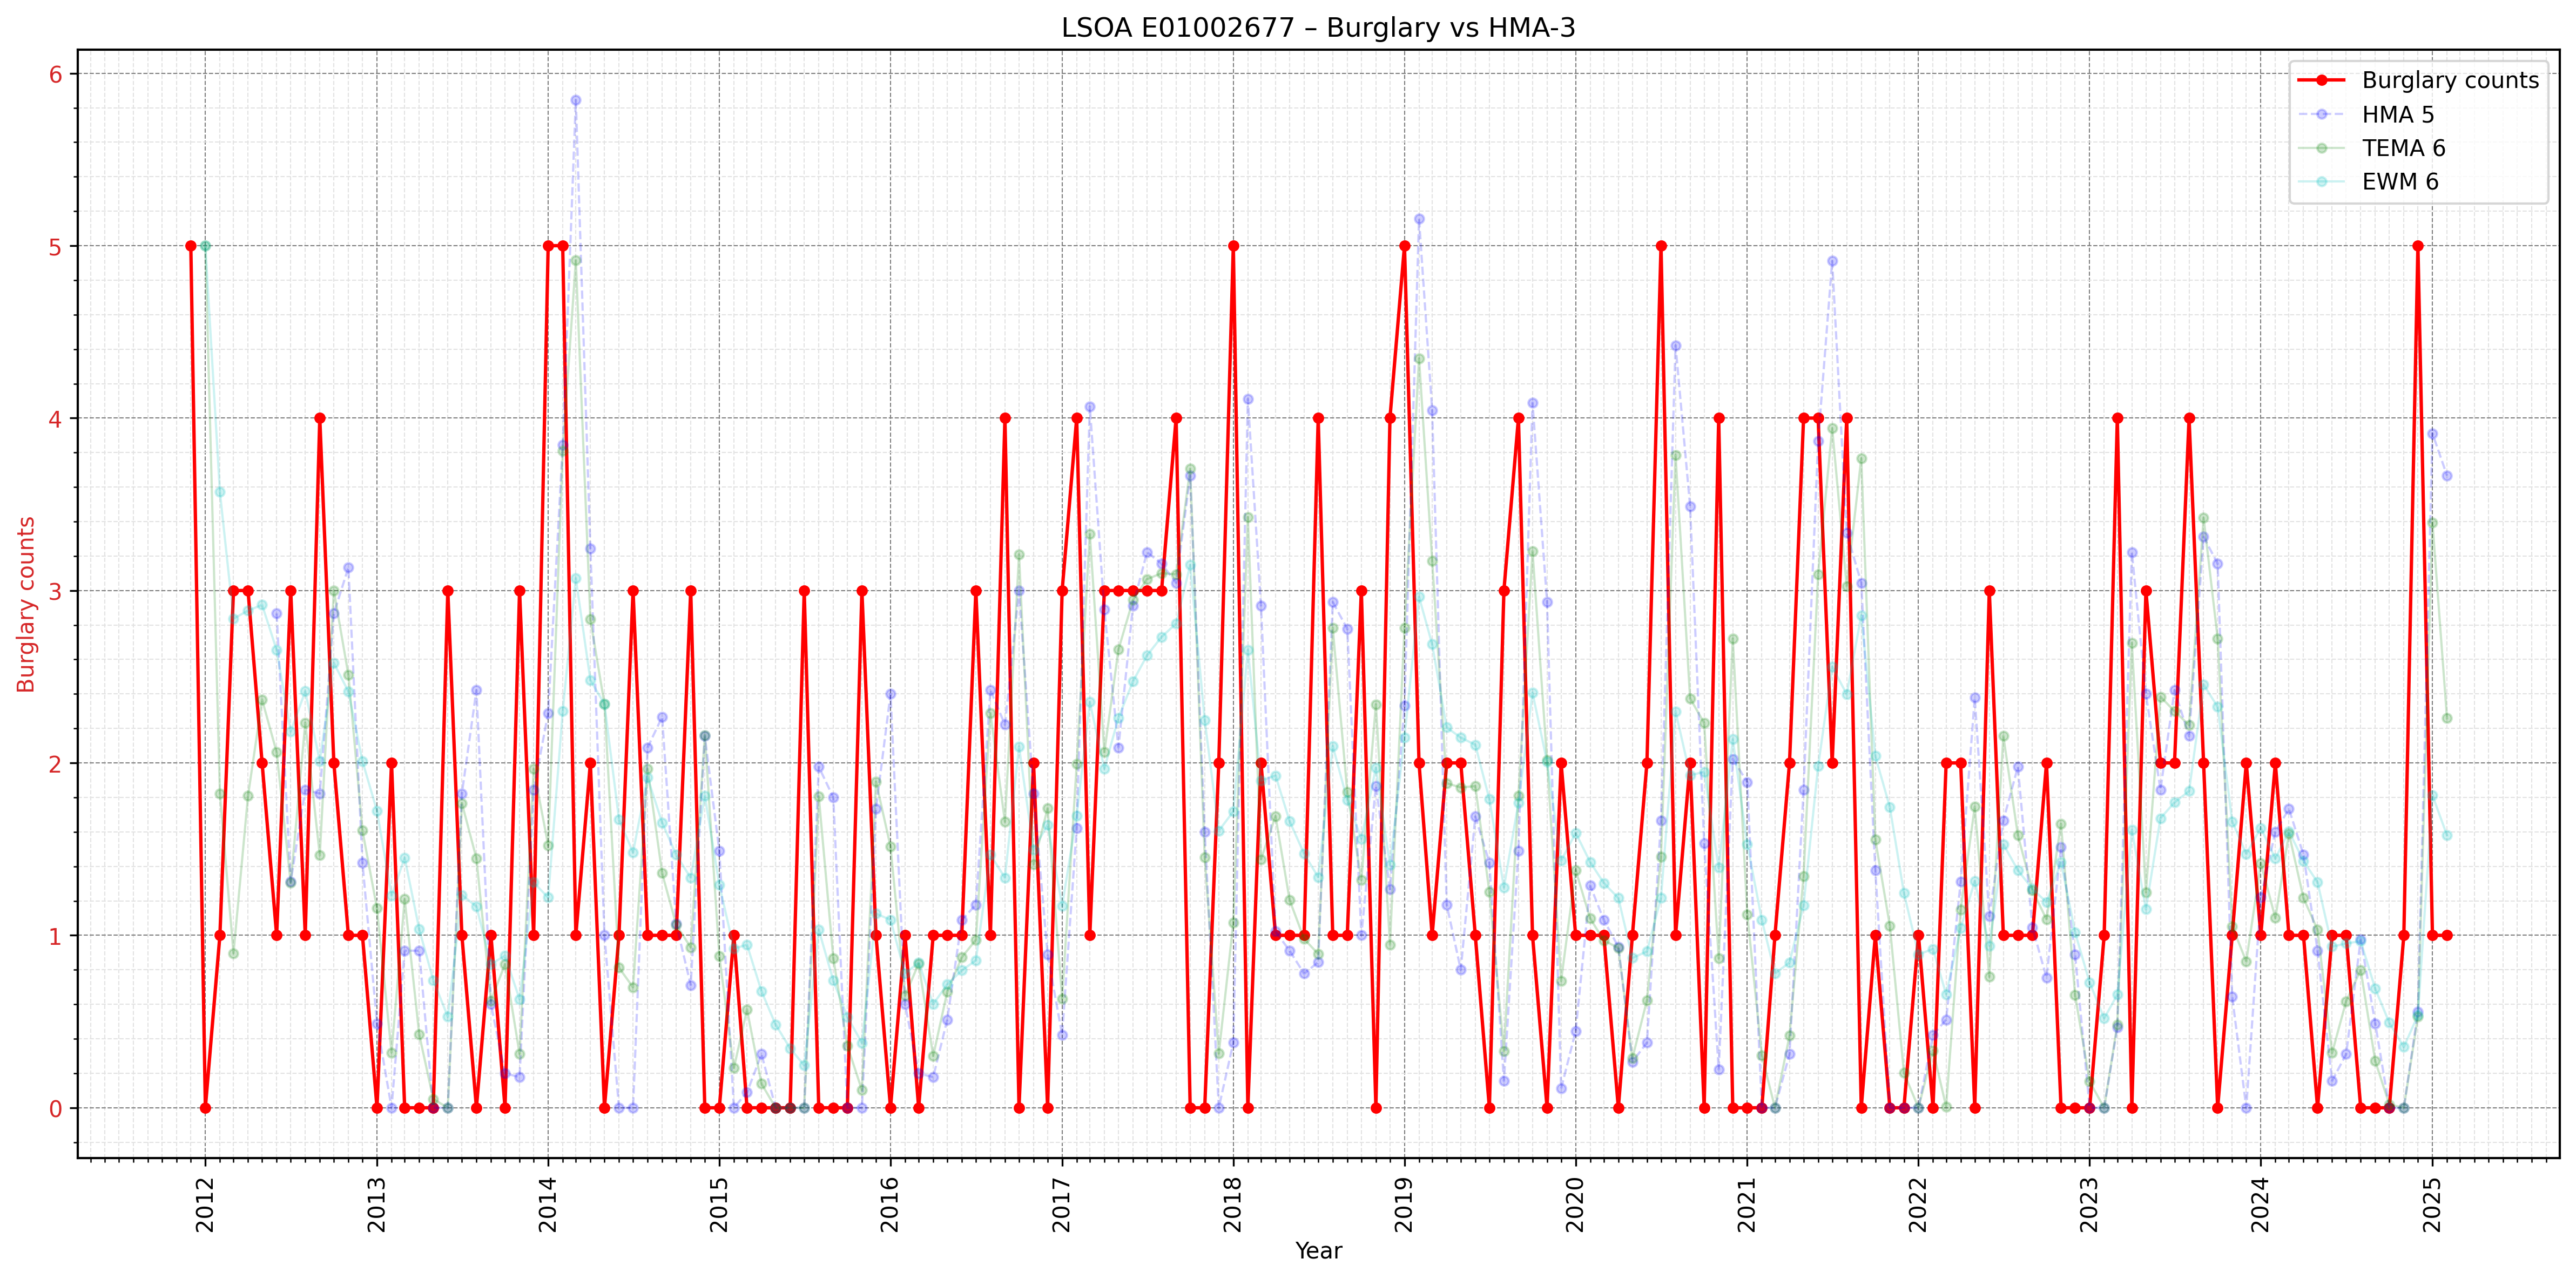

In [57]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 8), dpi=300)

# Plot burglary counts on left y-axis
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Burglary counts', color=color)
ax1.plot(train_dates, burglary_counts, 'r-', linewidth=1.5, label='Burglary counts', marker='o', markersize=4)
ax1.plot(train_dates, hma_5, 'b--', linewidth=1, label='HMA 5', marker='o', markersize=4, alpha=0.2)
ax1.plot(train_dates, tema_6, 'g-', linewidth=1, label='TEMA 6', marker='o', markersize=4, alpha=0.2)
ax1.plot(train_dates, ewm_6, 'c-', linewidth=1, label='EWM 6', marker='o', markersize=4, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

# Format x-axis
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=1, interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
fig.autofmt_xdate(ha='center', rotation=0)

ax1.set_title(f'LSOA {random_lsoa} – Burglary vs HMA-3')
# --- x-axis locators -------------------------------------------------------
ax1.xaxis.set_major_locator(mdates.YearLocator())           #  1-Jan every year
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))   # optional: show just the year
ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))  # every month

ax1.yaxis.set_minor_locator(AutoMinorLocator())

# --- gridlines -------------------------------------------------------------
ax1.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray')
ax1.grid(True, which='minor', linestyle='--', linewidth=0.5, color='#e3e3e3')
ax1.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.5, color='#e3e3e3')

# **Add a black outline (border) to the plot by customizing the spines**
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

ax1.legend(loc='upper right')

# Rotate x-axis tick labels
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

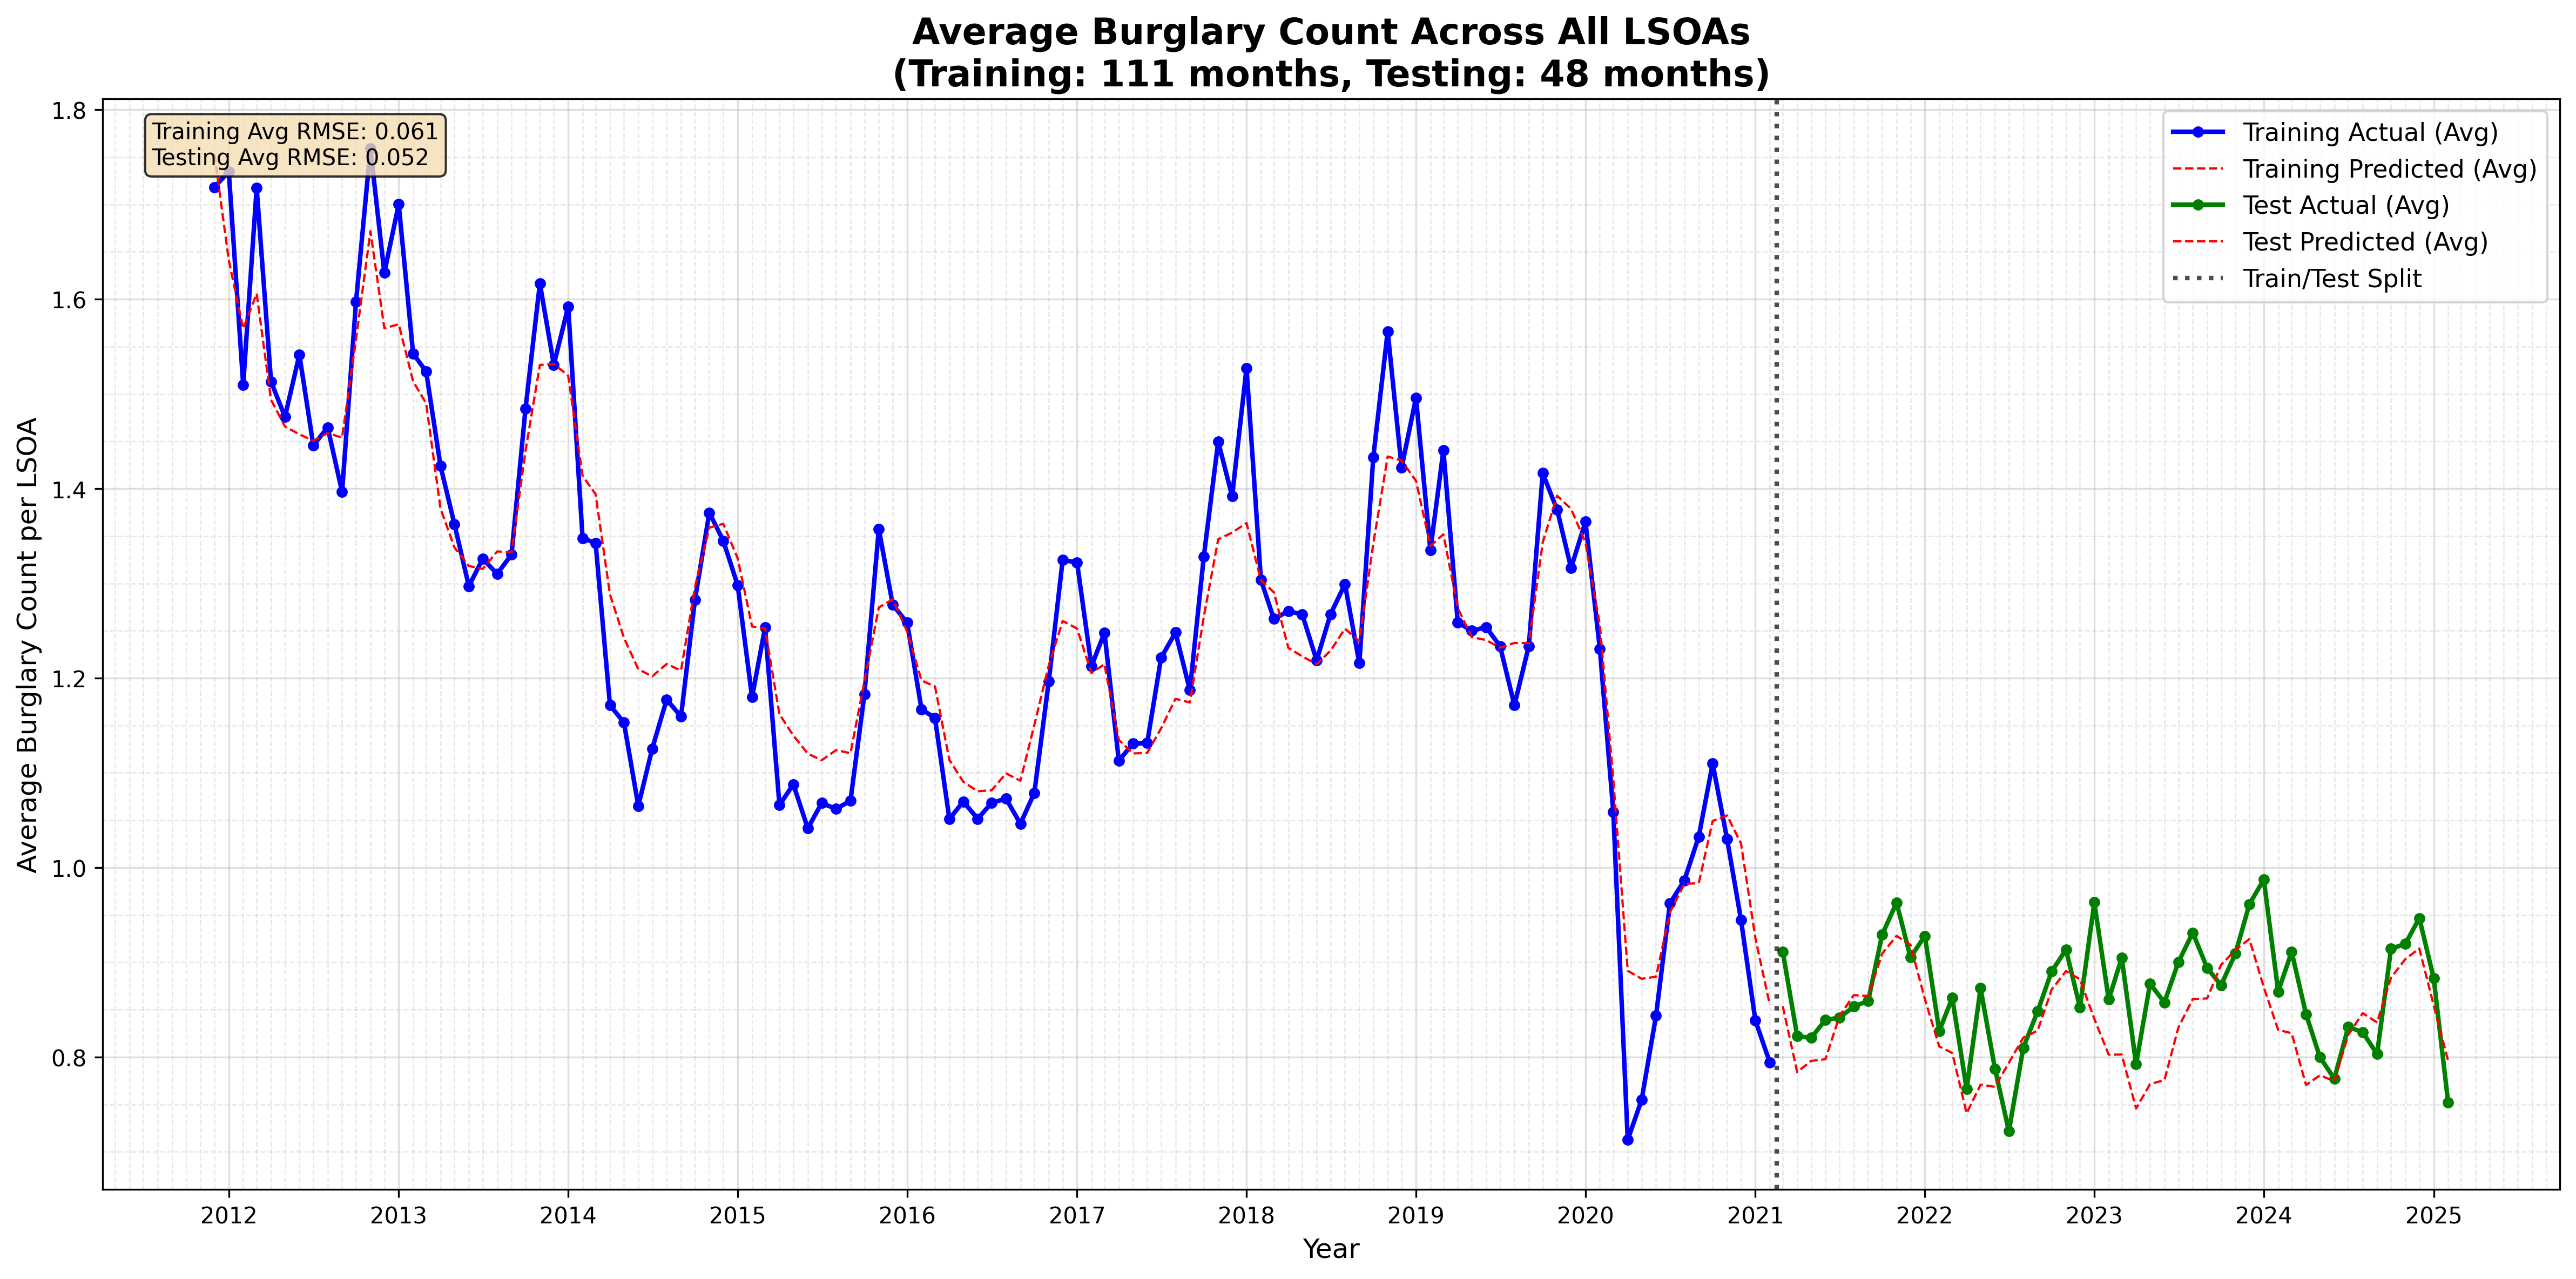

In [67]:
X_train = pl.read_parquet("../data/X_train.parquet").drop("LSOA code").to_numpy()
y_train = pl.read_parquet("../data/y_train.parquet").to_numpy().ravel()
X_test  = pl.read_parquet("../data/X_test.parquet").drop("LSOA code").to_numpy()
y_test  = pl.read_parquet("../data/y_test.parquet").to_numpy().ravel()

optimized_model = XGBRegressor(
    colsample_bytree=0.679486272613669,
    learning_rate=0.16678305712187014,
    max_depth=4,
    min_child_weight=8,
    n_estimators=468,
    subsample=0.9085081386743783,
    objective="count:poisson",
    eval_metric="rmse",
    tree_method="hist",
    random_state=42,
    early_stopping_rounds=72,
    n_jobs=-1
)

adjusted_model = optimized_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

train_df = pl.read_parquet("../data/X_train.parquet").with_columns(pl.read_parquet("../data/y_train.parquet"))
test_df = pl.read_parquet("../data/X_test.parquet").with_columns(pl.read_parquet("../data/y_test.parquet"))

# Get predictions
train_predictions = adjusted_model.predict(X_train)
test_predictions = adjusted_model.predict(X_test)

# Add predictions to dataframes
train_df = train_df.with_columns(pl.Series("predictions", train_predictions))
test_df = test_df.with_columns(pl.Series("predictions", test_predictions))

train_avg = (
    train_df
    .group_by(["time_index_norm", "year", "month"])
    .agg([
        pl.col("burglary_count").mean().alias("avg_actual"),
        pl.col("predictions").mean().alias("avg_predicted")
    ])
    .sort("time_index_norm")
)

test_avg = (
    test_df
    .group_by(["time_index_norm", "year", "month"])
    .agg([
        pl.col("burglary_count").mean().alias("avg_actual"),
        pl.col("predictions").mean().alias("avg_predicted")
    ])
    .sort("time_index_norm")
)

train_dates = pd.to_datetime({"year": train_avg["year"], "month": train_avg["month"], "day": 1})
test_dates  = pd.to_datetime({"year": test_avg["year"],  "month": test_avg["month"],  "day": 1})

train_actual_avg = train_avg["avg_actual"].to_list()
train_pred_avg   = train_avg["avg_predicted"].to_list()
test_actual_avg  = test_avg["avg_actual"].to_list()
test_pred_avg    = test_avg["avg_predicted"].to_list()

fig, ax = plt.subplots(figsize=(16, 8), dpi=300)

ax.plot(train_dates, train_actual_avg,  'b-',   linewidth=2, label='Training Actual (Avg)', marker='o', markersize=4)
ax.plot(train_dates, train_pred_avg,    'r--',  linewidth=1, label='Training Predicted (Avg)')
ax.plot(test_dates,  test_actual_avg,   'g-',   linewidth=2, label='Test Actual (Avg)',     marker='o', markersize=4)
ax.plot(test_dates,  test_pred_avg,     'r--',  linewidth=1, label='Test Predicted (Avg)')

# vertical split line at the boundary between the two date series
ax.axvline(train_dates.iloc[-1] + pd.Timedelta(days=15), color='black',
           linestyle=':', alpha=0.7, linewidth=2, label='Train/Test Split')

# date-axis formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=1, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
fig.autofmt_xdate(ha='center', rotation=0)

ax.set_title('Average Burglary Count Across All LSOAs\n(Training: 111 months, Testing: 48 months)',
             fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Average Burglary Count per LSOA', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.4)
ax.grid(True, which='major', linestyle='-',  linewidth=0.8, alpha=0.4)
ax.grid(True, which='minor', linestyle='--', linewidth=0.6, alpha=0.3)
ax.tick_params(axis='both', which='minor', length=0)
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())

# Add some statistics as text
train_rmse = np.sqrt(np.mean((np.array(train_actual_avg) - np.array(train_pred_avg))**2))
test_rmse = np.sqrt(np.mean((np.array(test_actual_avg) - np.array(test_pred_avg))**2))

plt.text(0.02, 0.98, f'Training Avg RMSE: {train_rmse:.3f}\nTesting Avg RMSE: {test_rmse:.3f}',
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()